# Gesture Recognition (RNN Study)

- In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

#!ls /datasets/Project_data/train

In [1]:
import numpy as np
import os
from skimage import io, transform
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
def fetch_data(path, ablation=None):
  train_doc = np.random.permutation(open(path  + 'train.csv').readlines())
  val_doc = np.random.permutation(open(path + 'val.csv').readlines())

  train_data = []
  val_data = []
  
  if ablation is not None:
    num_count = [0 for i in range(5)]
    for data in train_doc:
      label = int(data.split(';')[2])
      if num_count[label] < ablation:
        train_data.append(data)
        num_count[label] += 1

    num_count = [0 for i in range(5)]
    for data in val_doc:
      label = int(data.split(';')[2])
      if num_count[label] < ablation:
        val_data.append(data)
        num_count[label] += 1
  else:
    train_data = train_doc
    val_data = val_doc

  return train_data, val_data

In [4]:
train_doc, val_doc = fetch_data('/datasets/Project_data/')
batch_size = 32
img_dim_x = 64
img_dim_y = 64

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
img_idx = range(0, 30, 1)   #create a list of image numbers you want to use for a particular video

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)    
    x, y, z = len(img_idx), img_dim_x, img_dim_x

    while True:
        t = np.random.permutation(folder_list)
        t_len = len(t)

        if (t_len % batch_size) == 0:
          num_batches = (t_len // batch_size)
        else:
          num_batches = (t_len // batch_size) + 1

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, x, y, z, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output

            proc_batch_size = batch_size if ((batch + 1) * batch_size) < t_len else t_len % batch_size
            #print("t_len: %d, num_batches: %d, batch: %d, proc_batch_size: %d" % (t_len, num_batches, batch, proc_batch_size), end="")

            #image_name = []
            for folder in range(proc_batch_size):   # iterate over the batch_size
                imgs = sorted(os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])) # read all the images in the folder
                #imgs = str(folder + (batch * batch_size)) + source_path + '/' + t[folder + (batch * batch_size)].split(';')[0]

                for idx, item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image_name.append(imgs)
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape and the conv3D will throw error if the inputs in a batch have different shapes
                    resize_img = transform.resize(image, (y,z))
                    
                    batch_data[folder,idx,:,:,0] = resize_img[:,:,0] / 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resize_img[:,:,1] / 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resize_img[:,:,2] / 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

# write the code for the remaining data points which are left after full batches
        

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()

train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 40 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 40


In [7]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(len(images))
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

In [8]:
#test_gen = generator(train_path, train_doc, 32)
#d = next(test_gen)
#print(len(d[0]), end="\n",)
#plot_image(d[0][0])
#print(d[0], len(d[0]), end="\n",)

## Model Building

Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, GlobalAveragePooling3D, GlobalAveragePooling2D, ConvLSTM2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [10]:
input_dim = (len(img_idx), img_dim_x, img_dim_y, 3)

### Conv3D (experiment: 1)

- Set Initial Epochs = 20

experiment ='ex1'

model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_dim))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

### Conv3D (experiment: 2)

experiment ='ex2'

model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape = input_dim))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

### Conv3D (experiment: 3)
- changed Epochs = 40

experiment ='ex3'
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape = input_dim))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv3D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(GlobalAveragePooling3D())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

### Conv2D + GRU (experiment: 4)

experiment ='ex4'
model = Sequential()

model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape= input_dim))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

### Conv2D + ConvLSTM2D (experiment: 5)

In [11]:
experiment ='ex5'

model = Sequential()
model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape = input_dim))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
model.add(BatchNormalization())

model.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))
model.add(BatchNormalization())

model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

2023-02-20 09:13:45.062256: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-20 09:13:45.062319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [12]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 62, 62, 8)    224       
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 30, 62, 62, 8)    32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 60, 60, 16)   1168      
 tributed)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 30, 60, 60, 16)   64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 58, 58, 8)         6

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'model_init_' + experiment + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq = "epoch")

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience = 8, min_lr = 0.001, verbose = 1) 

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = (num_train_sequences // batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = (num_val_sequences // batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

In [16]:
#for i in range(steps_per_epoch):
#  data, label = next(train_generator)
#  print(len(data))

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [17]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 32
Epoch 1/40


2023-02-20 09:13:54.576660: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.5009 - categorical_accuracy: 0.2976Source path =  /datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_ex5_2023-02-2009_13_44.277088/model-00001-1.50094-0.29762-1.25968-0.14062.h5
21/21 [==============================] - 174s 8s/step - loss: 1.5009 - categorical_accuracy: 0.2976 - val_loss: 1.2597 - val_categorical_accuracy: 0.1406 - lr: 0.0010
Epoch 2/40
21/21 [==============================] - ETA: 0s - loss: 1.3103 - categorical_accuracy: 0.4315
Epoch 00002: saving model to model_init_ex5_2023-02-2009_13_44.277088/model-00002-1.31029-0.43155-1.27107-0.15625.h5
21/21 [==============================] - 170s 8s/step - loss: 1.3103 - categorical_accuracy: 0.4315 - val_loss: 1.2711 - val_categorical_accuracy: 0.1562 - lr: 0.0010
Epoch 3/40
21/21 [==============================] - ETA: 0s - loss: 1.1758 - categorical_accuracy: 0.4881
Epoch 00003: saving model to model_init_ex5_2023-02-2009_13_44.27

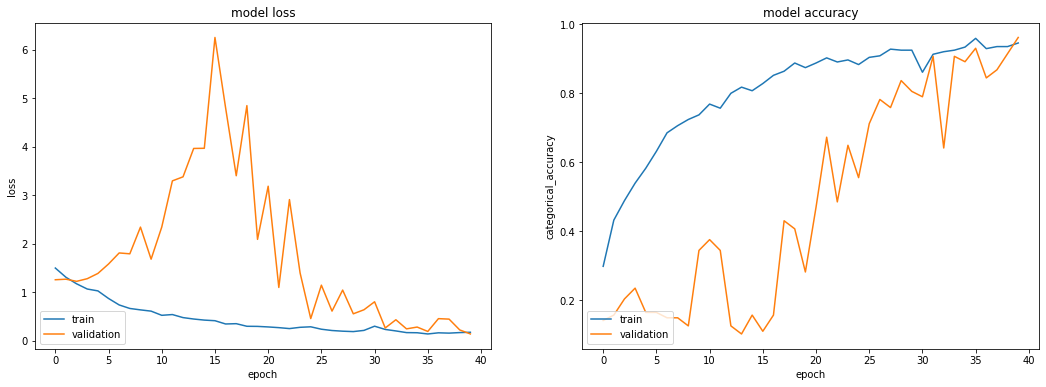

In [18]:
plt.figure(figsize=(18,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()